<a href="https://colab.research.google.com/github/Talendar/facial_expression_detection/blob/main/facial_expression_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection of facial expressions on the QIDER dataset**

In this notebook, we will train, using the QIDER (Tozadore et al., 2018) dataset, a convolutional neural network to detect human facial expressions in images. This notebook, as well as the dataset used and auxiliary Python modules can be found in [this](https://github.com/Talendar/facial_expression_detection) GitHub repository. Everything will be automatically downloaded bellow.

#### Authors:

*   Gabriel Nogueira (Talendar)

*   Marcel Ottoboni

#### References:

D. C. Tozadore, C. M. Ranieri, G. V. Nardari, R. A. F. Romero and V. C. Guizilini, "Effects of Emotion Grouping for Recognition in Human-Robot Interactions," 2018 7th Brazilian Conference on Intelligent Systems (BRACIS), Sao Paulo, 2018, pp. 438-443, doi: 10.1109/BRACIS.2018.00082.

### **1)  Installing and importing dependencies**

In [2]:
!pip install py7zr
import numpy as np
import zipfile

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import files
import shutil

### **2) Preparing and exploring the data**

#### **2.1) Downloading the dataset and auxiliary functions from GitHub**

In [3]:
!git clone https://github.com/Talendar/facial_expression_detection
%cd facial_expression_detection
from utils import *

Cloning into 'facial_expression_detection'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 73 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (73/73), done.
/content/facial_expression_detection



#### **2.2) Loading and normalizing the data**

The data is loaded with an external auxiliary function named *load_qider*. All the images are represented by a grayscale matrix, with individual cells (pixels) ranging from 0 (black) to 255 (white). The auxiliary function also normalizes the data, applying, for that, two steps.

In the first normalization step, all the images are resized to fixed and pre-determined dimensions, so that all of them end up with the same size. Different dimensions were tested. The one that yielded the best results was 32x32.

The second normalization step consists in dividing all the images matrices by 255. After that, each pixel's brightness/intensity is now determined by a float in the interval [0, 1].

In [4]:
img_dims = 32, 32

train_data, train_labels = load_qider("./data/QIDER/train", img_dims)
val_data, val_labels = load_qider("./data/QIDER/val", img_dims)
test_data, test_labels = load_qider("./data/test_imgs", img_dims)

print("  [TRAINING] DATA SHAPE: {}  |  LABELS SHAPE:  {}".format(train_data.shape, train_labels.shape))
print("[VALIDATION] DATA SHAPE: {}  |  LABELS SHAPE:  {}".format(val_data.shape, val_labels.shape))
print("      [TEST] DATA SHAPE: {}    |  LABELS SHAPE:  {}".format(test_data.shape, test_labels.shape))

  [TRAINING] DATA SHAPE: (2910, 32, 32, 1)  |  LABELS SHAPE:  (2910,)
[VALIDATION] DATA SHAPE: (1000, 32, 32, 1)  |  LABELS SHAPE:  (1000,)
      [TEST] DATA SHAPE: (14, 32, 32, 1)    |  LABELS SHAPE:  (14,)


#### **2.3) Visualizing the data**

First, let's check all the possible classes (each representing a facial expression) for the images. In the auxiliary module, a dictionary mapping each class/expression name to a integer code was declared.

In [5]:
print("Expressions and their codes: {}".format(EXPRESSIONS))

Expressions and their codes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Counting the number of occurences of each expression in the dataset:

In [6]:
exp_counts = {EXPRESSIONS[k]: 0 for k in EXPRESSIONS}

for d in train_labels:
    exp_counts[d] += 1
for d in val_labels:
    exp_counts[d] += 1

num_samples = len(train_labels) + len(val_labels)
for k in EXPRESSIONS:
    c = exp_counts[EXPRESSIONS[k]]
    print("%s: %d (%d%%)" % (k, c, 100*c/num_samples))

angry: 656 (16%)
disgust: 484 (12%)
fear: 390 (9%)
happy: 1211 (30%)
neutral: 161 (4%)
sad: 527 (13%)
surprise: 481 (12%)


Now, let's pick a sample batch of images and visualize them along with their classes.

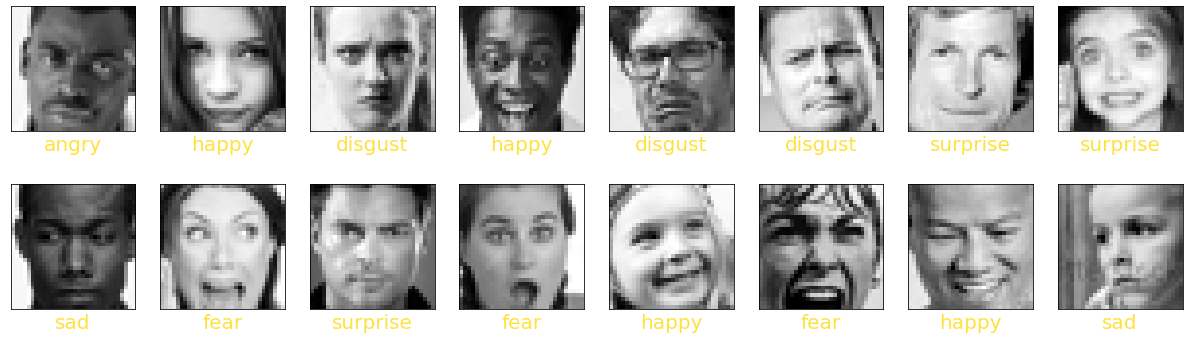

In [18]:
plt.figure(figsize=(21, 6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    img = randimg(train_data, train_labels)
    plt.imshow(img[0].reshape(img[0].shape[0], img[0].shape[1]), "gray")
    plt.xlabel(img[1], fontsize=20).set_color("#FFE13D")
plt.show()


#### **2.4) Data augmentation**

To increase the number of training examples, we use a sequence of keras layers to create different variations of the images. In order to do that, the images are translated, rotated, flipped and zoomed in or out. All this operations, when applied carefully to an image, generate a new image belonging to the same class of the original.

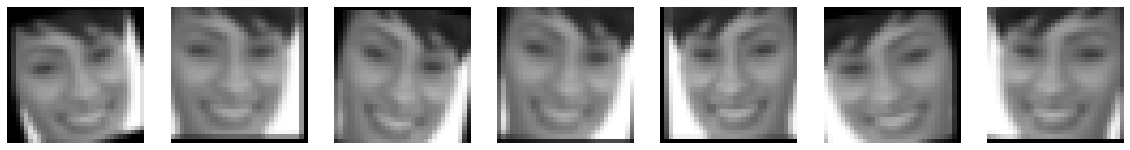

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", dtype="float32"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(.05, fill_mode="constant"),
  tf.keras.layers.experimental.preprocessing.RandomZoom(.07, .07, fill_mode="constant"),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(.05, .05, fill_mode="constant"),
])

# sample
idx = np.random.randint(0, len(train_data))
plt.figure(figsize=(20, 7))
for i in range(7):
    img = data_augmentation(tf.expand_dims(train_data[idx], 0))[0]
    ax = plt.subplot(1, 7, i + 1)
    plt.imshow(tf.reshape(img, (img.shape[0], img.shape[1])), "gray")
    plt.axis("off")

### **3) Building and training a model**

We now build and train a neural network model. Different topologies and hyperparameters were tested. The choice that yielded the best results is shown below (both in code and in text). The use of max-pooling layers did not improve the model's performance.

Different regularization techniques were tested, including: 1D and 2D dropout layers, L2 regularization, early stopping and batch normalization. Ultimately, the best results were achieved when only batch normalization was in use.


**Best choice of topology and hiperparameters:**

*   Layers (in order from the input layer to the output layer):
    *   4 identical convolutional layers with:
        *   64 filters;
        *   kernel size of 3x3;
        *   strides of 1x1;
        *   no padding (a.k.a "valid" padding);
        *   ReLU activation function;
    *   2 identical fully-connected (dense) layers with:
        *   64 neurons;
        *   ReLU activation function;
    *   1 fully-connected (dense) output layer with:
        *   7 neurouns (one for each class in the dataset);
        *   softmax activation function;
*   Loss function: cross-entropy;
*   Optimization method: Adaptive Moment Estimation (Adam);
    *   Learning rate: automacially choosen;
    *   Training epochs: 250;
*   Regularization techniques:
    *   Batch normalization.

<br>
Note: the data augmentation layers, "flatten" layers and batch normalization layers were not included in the layers list above, since the way they are implemented is a particularity of TensorFlow.

In [ ]:
tf.keras.backend.clear_session()

# building a model
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation='relu'),
    #tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(EXPRESSIONS), activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=["accuracy"])

# training
model.fit(train_data, train_labels, epochs=250,
              validation_data=(val_data, val_labels), 
              callbacks=[ClearCallback(), 
                         #EarlyStopping(monitor='val_loss', patience=20),
                         ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=1, save_best_only=True)
]);

# restoring the checkpoint of the best model
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=["accuracy"])

# evaluating
train_loss, train_acc = model.evaluate(train_data,  train_labels, verbose=0)
print('\nTraining loss: %.4f' % (train_loss))
print('Training accuracy: %.2f%%' % (train_acc * 100))

val_loss, val_acc = model.evaluate(val_data,  val_labels, verbose=0)
print('\nValidation loss: %.4f' % (val_loss))
print('Validation accuracy: %.2f%%' % (val_acc * 100))


Epoch 00250: val_accuracy did not improve from 0.69800
91/91 [==============================] - 1s 8ms/step - loss: 1.3879 - accuracy: 0.7749 - val_loss: 1.4825 - val_accuracy: 0.6830

Training loss: 1.3789
Training accuracy: 78.90%

Validation loss: 1.4693
Validation accuracy: 69.80%


In [ ]:
# downloading the last saved model
out_dir = "./saved_models/checkpoints/best_model"

shutil.make_archive(out_dir, 'zip', out_dir)
files.download(out_dir + ".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **4) Tests and results**

Now, let's evaluate the model on the test dataset and compare the results. Run the cell bellow if you want to run the tests using our best saved model.

In [11]:
# run this cell if you want to load our best model saved on GitHub
model_dir = "./saved_models/best_model"
with zipfile.ZipFile(model_dir + ".zip", 'r') as zip_ref:
    zip_ref.extractall(model_dir)

model = tf.keras.models.load_model(model_dir)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

Evaluating the model with the test data:

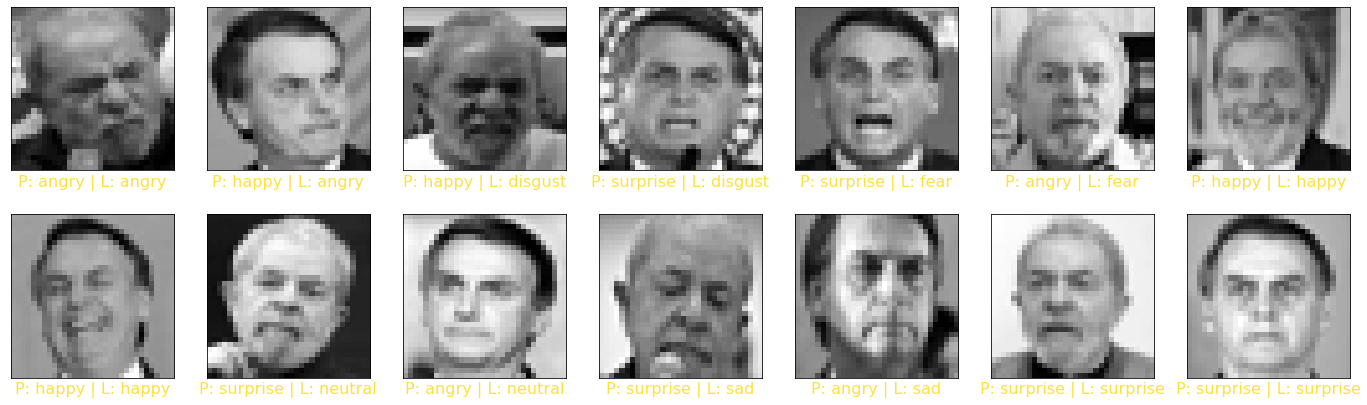



Test loss: 1.8208
Test accuracy: 35.71%


In [19]:
test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=0)
test_preds = np.argmax(model.predict(test_data), axis=1)

plt.figure(figsize=(24, 7))
for i in range(len(test_data)):
    plt.subplot(2, len(test_data)/2, i+1)
    plt.xticks([])
    plt.yticks([])
    img, label, pred = test_data[i], class_from_id(test_labels[i]), class_from_id(test_preds[i])
    plt.imshow(img.reshape(img.shape[0], img.shape[1]), "gray")
    plt.xlabel("P: %s | L: %s" % (pred, label), fontsize=16).set_color("#FFE13D")
plt.show()

print("\n\nTest loss: %.4f" % test_loss)
print("Test accuracy: %.2f%%" % (test_acc * 100))

The overall performance of the model in the different datasets can be seen in the table bellow.


<table width=60% align="left">
  <tr>
    <td><b><center><p>Data</p></center></b></td>
    <td><b><center><p>Loss</p></center></b></td>
    <td><b><center><p>Accuracy</p></center></b></td>
  </tr>
  <tr>
    <td><center><p>Training</p></center></td>
    <td><center><p>1.3789</p></center></td>
    <td><center><p>78.90%</p></center></td>
  </tr>
  <tr>
    <td><center><p>Validation</p></center></td>
    <td><center><p>1.4693</p></center></td>
    <td><center><p>69.80%</p></center></td>
  </tr>
  <tr>
    <td><center><p>Test</p></center></td>
    <td><center><p>1.8208</p></center></td>
    <td><center><p>35.71%</p></center></td>
  </tr>
</table>